In [43]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [44]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [45]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [46]:
print(len(training_data),len(validation_data),len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 64).

#### MLP Class

In [47]:
# define a method that provides an instance of an MLP which uses as a list of units per layer as input

#device = "cpu"
device = "cuda"

def mlp(units = [28*28, 200, 10]):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers).
    """

    seq = [torch.nn.Flatten()]

    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i], units[i+1], device=device))
        seq.append(torch.nn.ReLU())
    seq.append(torch.nn.Linear(units[-2], units[-1], device=device))
    #seq.append(torch.nn.Softmax(dim=1))

    return torch.nn.Sequential(*seq)

In [48]:
# create an instance and its summary

model = mlp().to(device)
from torchsummary import summary
summary(model, (1,28,28))
print(f"Model on cuda: {next(model.parameters()).is_cuda}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                   [-1, 10]           2,010
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.61
Estimated Total Size (MB): 0.62
----------------------------------------------------------------
Model on cuda: True


#### Training Loop 

In [49]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, doPrint=True):
    """
    Performs the training of a model with given learning rate (lr), 
    number of epochs (nepochs), batchsize (nbatch) and training and validation data.
    Suitable data loaders are instantiated for the training and validation datasets.
    Keep book about cost and accuracy (per epoch) for both training and validation set.
    """
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    #device = "cpu"
    device = "cuda"
    
    cost_ce = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    training_loader = DataLoader(dataset=training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(dataset=validation_data, batch_size=nbatch, shuffle=True)

    size = len(training_loader.dataset)
    nbatches = len(training_loader)
    size_val = len(validation_loader.dataset)
    nbatches_val = len(validation_loader)
    
    for epoch in range(nepochs):
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            X = X.to(device)
            Y = Y.to(device)
            pred = model(X)
            loss = cost_ce(pred, Y)
            
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
            
            #gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Adjust cost and accuracy with batch size
        cost /= nbatches
        acc /= size
        
        acc_val = 0.0
        cost_val = 0.0
        with torch.no_grad(): #no gradients for validation
            for (X, Y) in validation_loader:
                X = X.to(device)
                Y = Y.to(device)
                pred = model(X)
                acc_val += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
                loss_val = cost_ce(pred, Y)
                cost_val += loss_val.item()

            cost_val /= nbatches_val
            acc_val /= size_val
    
        cost_hist.append(cost)
        cost_hist_test.append(cost_val)
        acc_hist.append(acc)
        acc_hist_test.append(acc_val)
        
        if doPrint:
            print(f"Epoch {epoch+1}:, {cost}, {acc}, {cost_val}, {acc_val}")

    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

64 49936
         cost,  accuracy,  cost_val,  accuracy_val
Epoch 1:, 2.3273093700408936, 0.109375, 2.26537837648088, 0.2311
Epoch 2:, 2.2236835956573486, 0.34375, 2.2231608727935015, 0.2366
Epoch 3:, 2.1458945274353027, 0.390625, 2.186165255346116, 0.2532
Epoch 4:, 2.0744786262512207, 0.421875, 2.14983957588293, 0.2416
Epoch 5:, 2.007962226867676, 0.375, 2.114824001196843, 0.2422
Epoch 6:, 1.9449570178985596, 0.40625, 2.077308313861774, 0.2544
Epoch 7:, 1.883273720741272, 0.421875, 2.0353826534975865, 0.2845
Epoch 8:, 1.8217936754226685, 0.453125, 1.9924184364877688, 0.3151
Epoch 9:, 1.7608414888381958, 0.453125, 1.9485173506341922, 0.3392
Epoch 10:, 1.7007102966308594, 0.46875, 1.9037003684195744, 0.3638
Epoch 11:, 1.6410672664642334, 0.46875, 1.8578677162243302, 0.3866
Epoch 12:, 1.5819426774978638, 0.515625, 1.8118588127148378, 0.4049
Epoch 13:, 1.5238343477249146, 0.546875, 1.7665934076734409, 0.418
Epoch 14:, 1.467225432395935, 0.5625, 1.7248341710704147, 0.4297
Epoch 15:, 1.4125

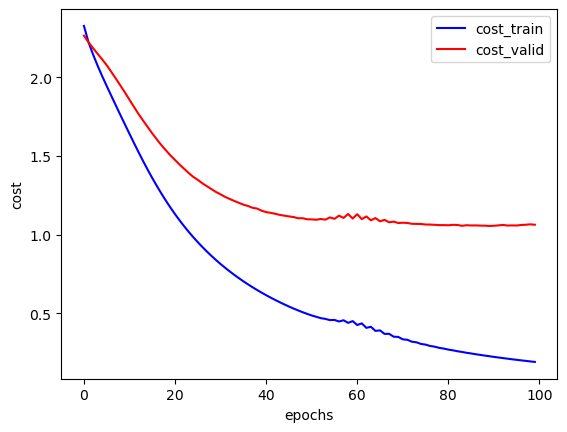

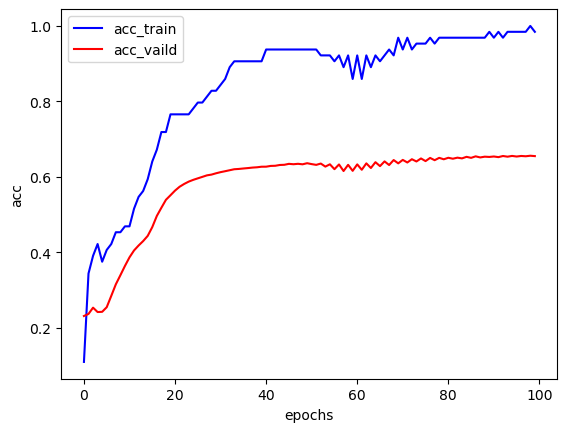

In [50]:
nbatch = 64
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches*nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
print(len(trainset), len(rest))

print("         cost,  accuracy,  cost_val,  accuracy_val")
model = mlp([28*28, 200, 10])
cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

plt.figure(1)
plt.plot(range(nepochs), cost_train, "b-", label="cost_train")
plt.plot(range(nepochs), cost_valid, "r-", label="cost_valid")
plt.xlabel("epochs")
plt.ylabel("cost")
plt.legend()

plt.figure(2)
plt.plot(range(nepochs), acc_train, "b-", label="acc_train")
plt.plot(range(nepochs), acc_valid, "r-", label="acc_vaild")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

> We noticed that when we add a Softmax layer in the end the end overfitting does not occur in the first 100 epochs. Without that layer we can clearly see overfitting. Why is that?

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 64 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

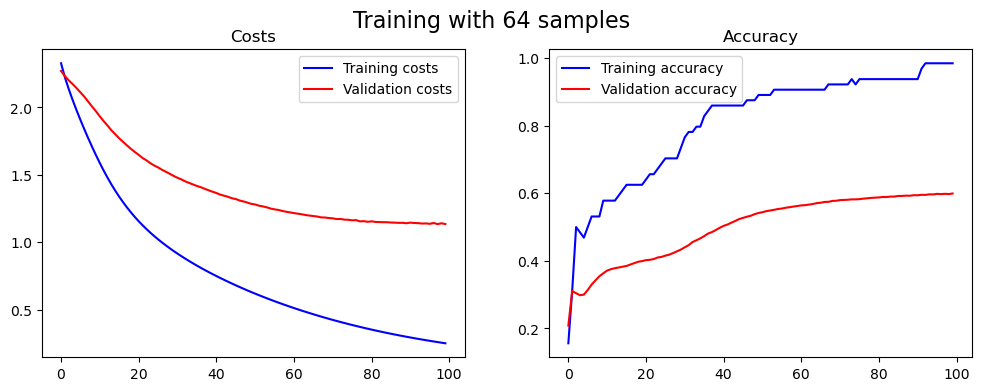

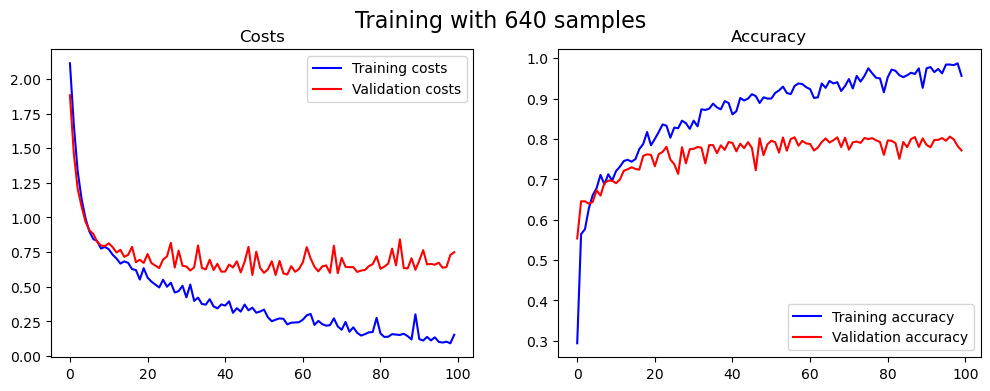

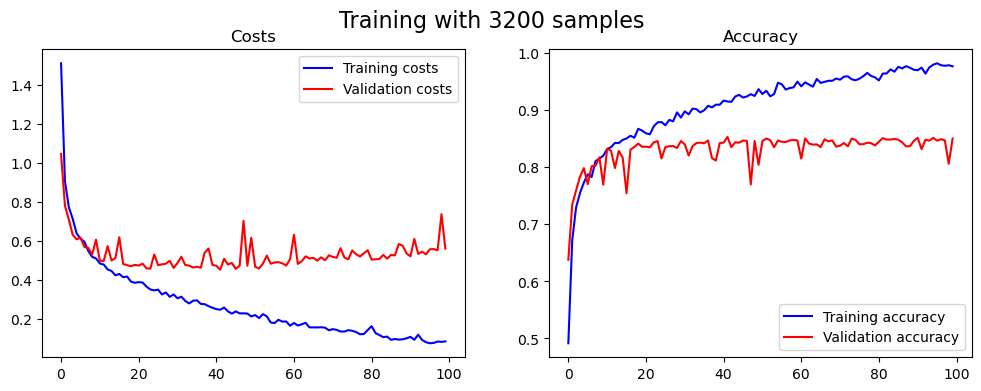

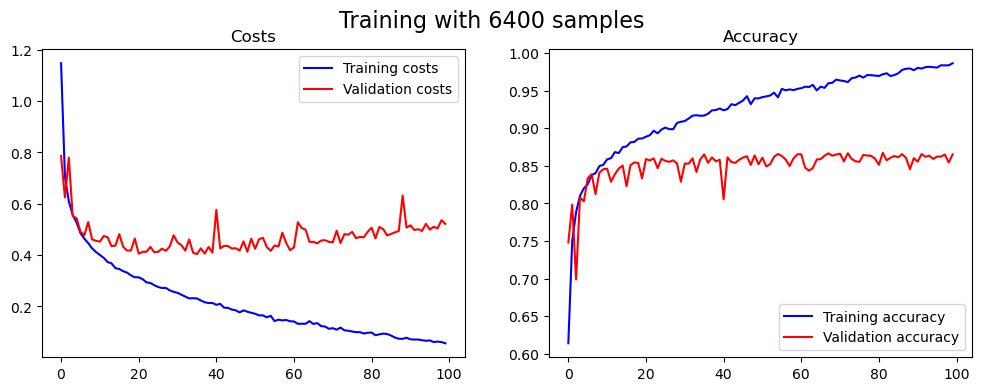

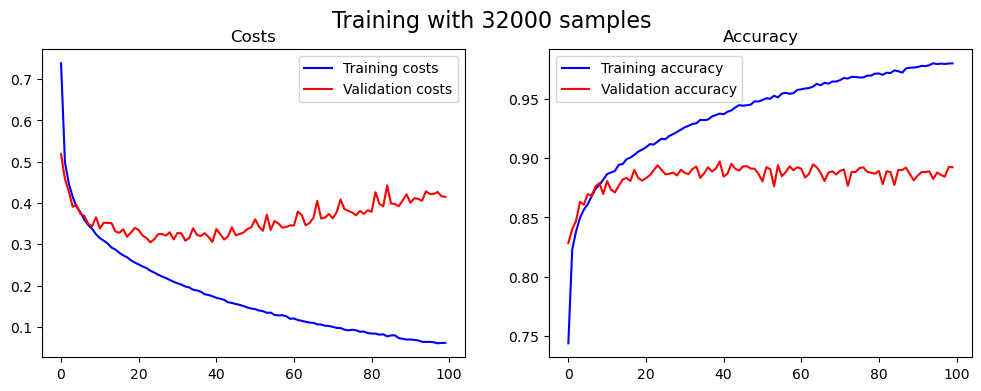

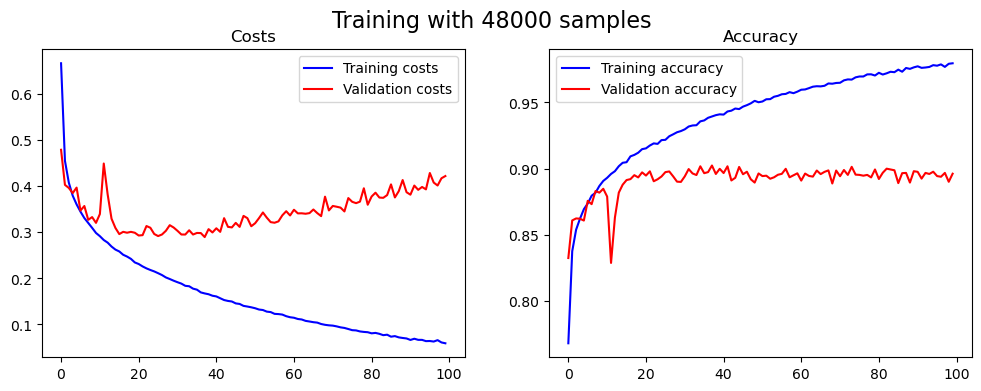

In [51]:
# CAUTION: THIS TAKES A WHILE TO RUN!!
nbatch = 64
nepochs = 100
lr = 0.1

nbatches_list = [1, 10, 50, 100, 500, 750]

for nbatches in nbatches_list:
    trainsize = nbatches*nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])
    model = mlp([28*28, 200, 10])
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data, doPrint=False)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    fig.suptitle('Training with {0} samples'.format(str(len(trainset))), fontsize=16)
    axs[0].set_title("Costs")
    axs[0].plot(range(nepochs), cost_train, "b-", label="Training costs")
    axs[0].plot(range(nepochs), cost_valid, "r-", label="Validation costs")
    axs[0].legend()
    axs[1].set_title("Accuracy")
    axs[1].plot(range(nepochs), acc_train, "b-", label="Training accuracy")
    axs[1].plot(range(nepochs), acc_valid, "r-", label="Validation accuracy")
    axs[1].legend()
    plt.show()

#### Comments: YOUR comments
**64 samples**: we can clearly see overfitting starting already early on. But at around epoch 20 the validation accuracy and the test accuracy diverge hard. 64 samples are definitely not enough. Final validation accuracy around 0.60  
**640 samples**: still in the overfitting regime but much better already than before. Still not enough training samples. Final validation accuracy around 0.75  
**3200 samples**: still in the overfitting regime but much better again. Final validation accuracy around 0.82    
**6400 samples**: still in the overfitting regime, not much better than before. Final validation accuracy around 0.84  
**32000 samples**: still in the overfitting regime, not much better than before. Final validation accuracy around 0.87  
**48000 samples**: still in the overfitting regime, not much better than before. Final validation accuracy around 0.88   
Having more training data is obviously always better. But The improvement in the end is marginal (especially considering how much more data we're using). Probably we need at least 2500 samples to get a decent result (> 0.80 on validation set). But there is not much more room for improvement with this rather simple model. 

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

Different single-layer models:
Model on cuda: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
              ReLU-3                   [-1, 50]               0
            Linear-4                   [-1, 10]             510
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
Epoch 1:, 0.629640259229771, 0.77582, 0.5730895889792472, 0.7806
Epoch 2:, 0.44222886134367767, 0.83922, 0.4322341176544785, 0.8423
Epoch 3:, 0.4007406625563226, 0.85364, 0.4070887775367992, 0.8539
Epoch 4:, 0.37750695208492485, 0.8612, 0.4233062478

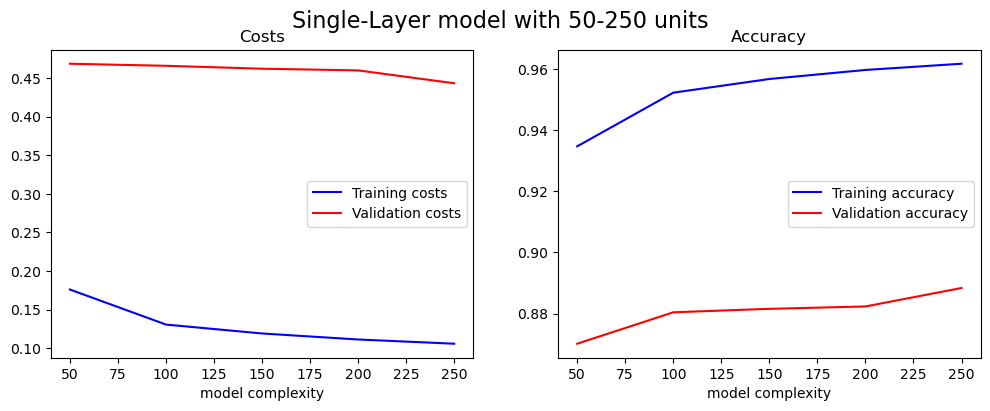

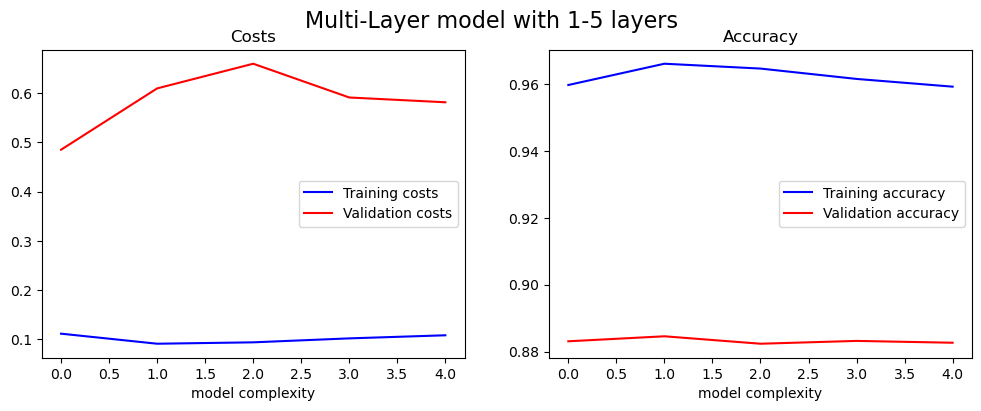

In [52]:
# several iterations with the code snippets of the form:

nbatch = 64
nepochs = 150
lr = 0.15

device = 'cuda'

sl_cost_train_hist = []
sl_acc_train_hist = []
sl_cost_val_hist = []
sl_acc_val_hist = []

ml_cost_train_hist = []
ml_acc_train_hist = []
ml_cost_val_hist = []
ml_acc_val_hist = []

# different single-layer sizes
print("Different single-layer models:")
for i in range(50, 300, 50):
    model = mlp([28*28, i, 10]).to(device)
    print(f"Model on cuda: {next(model.parameters()).is_cuda}")
    summary(model, (1,28,28))
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)
    
    sl_cost_train_hist.append(cost_train)
    sl_acc_train_hist.append(acc_train)
    sl_cost_val_hist.append(cost_valid)
    sl_acc_val_hist.append(acc_valid)


print("Different multi-layer models:")
# multiple layers with same size
layers = [28*28, 10]
for i in range(5):

    layers.insert(-1, 200) # insert linear/ReLU layer

    model = mlp(layers).to(device)
    print(f"Model on cuda: {next(model.parameters()).is_cuda}")
    summary(model, (1,28,28))
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, training_data, validation_data)

    ml_cost_train_hist.append(cost_train)
    ml_acc_train_hist.append(acc_train)
    ml_cost_val_hist.append(cost_valid)
    ml_acc_val_hist.append(acc_valid)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.suptitle(f'Single-Layer model with 50-250 units', fontsize=16)
axs[0].set_title("Costs")
axs[0].plot(range(50, 300, 50), np.mean(sl_cost_train_hist, axis=1), "b-", label="Training costs")
axs[0].plot(range(50, 300, 50), np.mean(sl_cost_val_hist, axis=1), "r-", label="Validation costs")
axs[0].legend()
axs[0].set_xlabel("model complexity")
axs[1].set_title("Accuracy")
axs[1].plot(range(50, 300, 50), np.mean(sl_acc_train_hist, axis=1), "b-", label="Training accuracy")
axs[1].plot(range(50, 300, 50), np.mean(sl_acc_val_hist, axis=1), "r-", label="Validation accuracy")
axs[1].legend()
axs[1].set_xlabel("model complexity")
plt.show()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.suptitle(f'Multi-Layer model with 1-5 layers', fontsize=16)
axs[0].set_title("Costs")
axs[0].plot(range(5), np.mean(ml_cost_train_hist, axis=1), "b-", label="Training costs")
axs[0].plot(range(5), np.mean(ml_cost_val_hist, axis=1), "r-", label="Validation costs")
axs[0].legend()
axs[0].set_xlabel("model complexity")
axs[1].set_title("Accuracy")
axs[1].plot(range(5), np.mean(ml_acc_train_hist, axis=1), "b-", label="Training accuracy")
axs[1].plot(range(5), np.mean(ml_acc_val_hist, axis=1), "r-", label="Validation accuracy")
axs[1].legend()
axs[1].set_xlabel("model complexity")
plt.show()



> Conclusion: Deeper networks need more training, because they converge slower. The performance increases with deeper networks. But there is no point to make ultra-deep networks because there is a tradeoff between complexity and training effort.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [53]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

#device = "cpu"
device = "cuda"

def mlp_dropout(units = [28*28, 200, 10], p_in = 0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """
    seq = [torch.nn.Flatten()]
    seq.append(torch.nn.Dropout(p=p_in))

    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i], units[i+1], device=device))
        seq.append(torch.nn.ReLU())
        seq.append(torch.nn.Dropout(p=p_hidden))
    seq.append(torch.nn.Linear(units[-2], units[-1], device=device))
    seq.append(torch.nn.Softmax(dim=1))

    return torch.nn.Sequential(*seq)

    

In [54]:
model = mlp_dropout([28*28,200,10])

from torchsummary import summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
           Softmax-7                   [-1, 10]               0
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

Different multi-layer models:
Model on cuda: True
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
            Linear-3                  [-1, 200]         157,000
              ReLU-4                  [-1, 200]               0
           Dropout-5                  [-1, 200]               0
            Linear-6                   [-1, 10]           2,010
           Softmax-7                   [-1, 10]               0
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.61
Estimated Total Size (MB): 0.63
----------------------------------------------------------------
Epoch 1:, 2.302601397037506, 0.08984375, 2.3000340993237

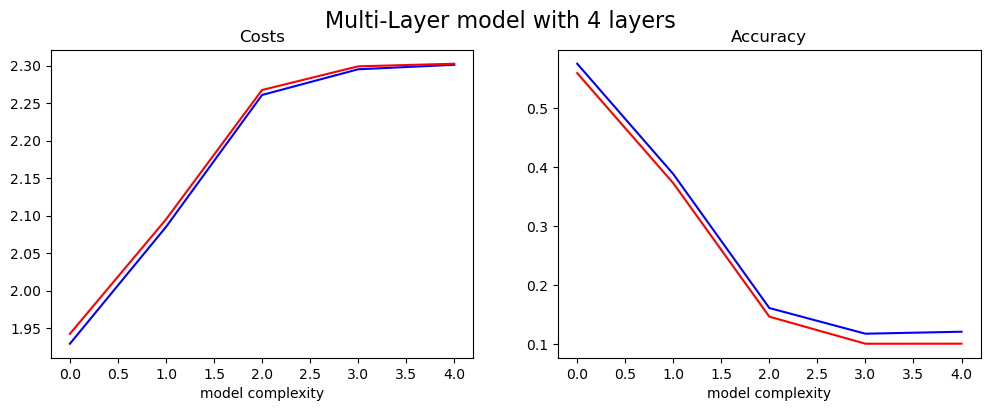

In [55]:
nbatch = 64
nbatches = 8
nepochs = 100
lr = 0.1

device = 'cuda'

ml_cost_train_hist = []
ml_acc_train_hist = []
ml_cost_val_hist = []
ml_acc_val_hist = []


print("Different multi-layer models:")
# multiple layers with same size
layers = [28*28, 10]
model_list = []
for i in range(5):
    trainsize = nbatches*nbatch
    trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000-trainsize])

    layers.insert(-1, 200) # insert linear/ReLU layer
    model = mlp_dropout(layers).to(device)
    model_list.append(model)
    print(f"Model on cuda: {next(model.parameters()).is_cuda}")
    summary(model, (1,28,28))
    cost_train, cost_valid, acc_train, acc_valid = train_eval(model, lr, nepochs, nbatch, trainset, validation_data)

    ml_cost_train_hist.append(cost_train)
    ml_acc_train_hist.append(acc_train)
    ml_cost_val_hist.append(cost_valid)
    ml_acc_val_hist.append(acc_valid)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
fig.suptitle(f'Multi-Layer model with {i} layers', fontsize=16)
axs[0].set_title("Costs")
axs[0].plot(range(5), np.mean(ml_cost_train_hist, axis=1), "b-", label="Training costs")
axs[0].plot(range(5), np.mean(ml_cost_val_hist, axis=1), "r-", label="Validation costs")
#axs[0].legend()
axs[0].set_xlabel("model complexity")
axs[1].set_title("Accuracy")
axs[1].plot(range(5), np.mean(ml_acc_train_hist, axis=1), "b-", label="Training accuracy")
axs[1].plot(range(5), np.mean(ml_acc_val_hist, axis=1), "r-", label="Validation accuracy")
#axs[1].legend()
axs[1].set_xlabel("model complexity")
plt.show()

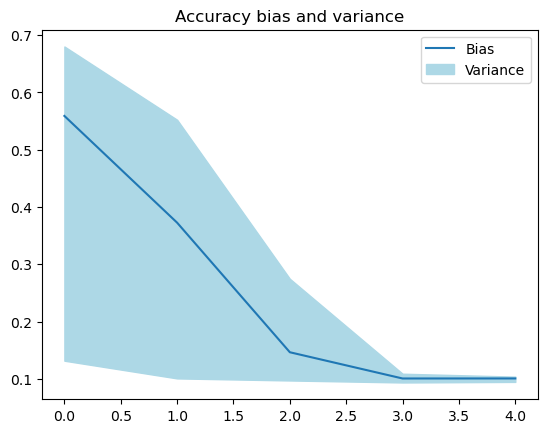

In [56]:
plt.title("Accuracy bias and variance")
plt.plot(range(5), np.mean(ml_acc_val_hist, axis=1), label="Bias")
plt.fill_between(range(5), y1=np.min(ml_acc_val_hist, axis=1), y2=np.max(ml_acc_val_hist, axis=1), label="Variance", color="lightblue")
plt.legend()
plt.show()